In [45]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import splines
import statsmodels.api as sm
from scipy.ndimage.filters import gaussian_filter1d

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

merged_bins          = 10
sigma                = 50/merged_bins
history_length       = 100/merged_bins

with np.load('data.npz') as archive:
    cond_A = reduce_resolution(archive['spikes_competitionA'],merged_bins)[:,0,:,:]
    cond_B = reduce_resolution(archive['spikes_competitionB'],merged_bins)[:,0,:,:]
    cond_X = reduce_resolution(archive['spikes_competitionTest'],merged_bins)[:,0,:,:]
cells, N, T = cond_A.shape
N_test = cond_X.shape[1]

spikes = np.zeros((cells,2,N,T))
spikes[:,0,:,:] = cond_A
spikes[:,1,:,:] = cond_B

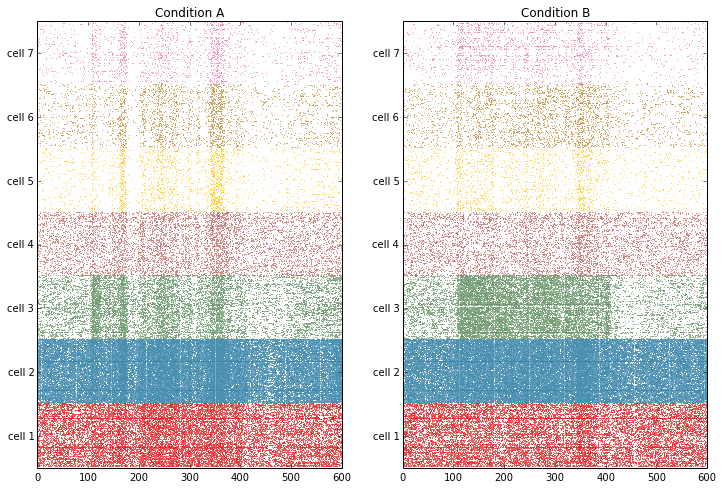

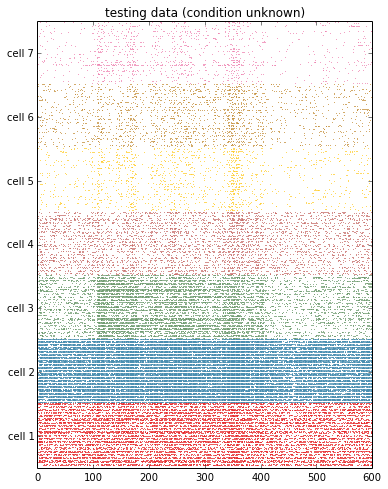

In [84]:
figure(figsize = (12,8))
ax = [subplot(1,2,1), subplot(1,2,2)]
for cond in range(2):
    for cell in range(cells):
        spike_y, spike_t = np.nonzero(cond_A[cell] if cond == 0 else cond_B[cell])
        ax[cond].plot(spike_t,N*(cell+1)-spike_y, ",", color=cm.Set1(float(cell)/cells), alpha=0.7,ms=3)
    ax[cond].set_ylim([0,cells*N])
    ax[cond].set_yticks(np.linspace(N/2, N/2 + N*cells, cells, endpoint=False));
    ax[cond].set_yticklabels(["cell %d" % (v+1) for v in range(cells)]);
    ax[cond].set_title("Condition A" if cond == 0 else "Condition B")

figure(figsize = (6,8))
for cell in range(cells):
    spike_y, spike_t = np.nonzero(cond_X[cell])
    plot(spike_t,N_test*(cell+1)-spike_y, ",", color=cm.Set1(float(cell)/cells), alpha=0.7,ms=3)
ylim([0,cells*N_test])
yticks(np.linspace(N_test/2, N_test/2 + N_test*cells, cells, endpoint=False));
gca().set_yticklabels(["cell %d" % (v+1) for v in range(cells)]);
title("testing data (condition unknown)")

In [6]:
def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles
    
def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))

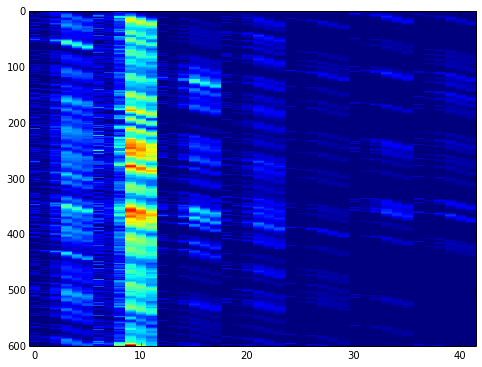

In [72]:
def calculate_history_dm(cell_spiketrains, num_knots=5, history_length=20, order=3):
    """ Calculates a history design matrix for a single trial and multiple neurons """
    if cell_spiketrains.ndim == 1:
        cell_spiketrains = cell_spiketrains.reshape((1,-1))
    knots   = splines.augknt(np.logspace(0,np.log10(history_length),num_knots),order)[:-1]                       
    bases   = splines.spcol(np.linspace(1+1e-10,history_length,history_length),knots,order)
    kernels = np.vstack([np.zeros_like(bases), bases])
    dm_cols = []
    for i,spiketrain in enumerate(cell_spiketrains):
        for j,kernel in enumerate(kernels.T):
            dm_cols.append(np.convolve(spiketrain, kernel,"same"))
    return np.vstack(dm_cols).T

figure(figsize=(8,6))
imshow(calculate_history_dm(spikes[:,0,0,:]),aspect='auto',interpolation='nearest')

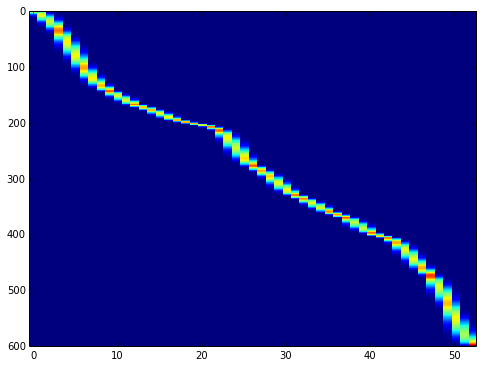

In [71]:
def calculate_rate_dm(trial_spiketrains, num_knots=50, order=3, sigma=10):
    cum_d   = calc_cum_abs_deriv(trial_spiketrains.sum(axis=0), sigma=sigma, order=1)
    knots   = splines.augknt(find_percentiles(cum_d, num_knots), order)
    return np.array(splines.spcol(range(int(knots[-1]+0.5)),knots,order))

figure(figsize=(8,6))
imshow(calculate_rate_dm(spikes[0,0,:,:]),aspect='auto',interpolation='nearest')

In [17]:
num_rate_knots       = 50
rate_spline_order    = 3
history_spline_order = 3

history_num_knots       = 5

In [74]:
# each cell has a different rate design matrix for each condition, but they are identical across trials
# each cell has the same history design matrix, but there is one for each condition and trial

rate_dms = []
for cell in range(cells):
    rate_dms.append([])
    for condition in range(2):
        # calculate rate design matrix
        rate_dm = calculate_rate_dm(spikes[cell,condition,:,:], num_knots=num_rate_knots, order=rate_spline_order, sigma=sigma)
        rate_dms[cell].append(rate_dm)

history_dms = []
for condition in range(2):
    history_dms.append([])
    for trial in range(N):
        # calculate history design matrix
        history_dm = calculate_history_dm(spikes[:,condition,trial,:], num_knots=history_num_knots, history_length=history_length, order=history_spline_order)
        history_dms[condition].append(history_dm)

In [78]:
models = []
for cell in range(cells):
    models.append([])
    for condition in range(2):
        print "Fitting model for cell %d on condition %d" % (cell, condition)
        dm = np.array(np.bmat([[history_dms[condition][trial], rate_dms[cell][condition]] for trial in range(N)]))
        
        spikes_nospikes = np.array([spikes[cell,condition,:,:].ravel(), merged_bins-spikes[cell,condition,:,:].ravel()]).T
        model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
        fitted_model = model.fit()
        fitted_model.remove_data()
        
        models[cell].append(fitted_model);

Fitting model for cell 0 on condition 0
Fitting model for cell 0 on condition 1
Fitting model for cell 1 on condition 0
Fitting model for cell 1 on condition 1
Fitting model for cell 2 on condition 0
Fitting model for cell 2 on condition 1
Fitting model for cell 3 on condition 0
Fitting model for cell 3 on condition 1
Fitting model for cell 4 on condition 0
Fitting model for cell 4 on condition 1
Fitting model for cell 5 on condition 0
Fitting model for cell 5 on condition 1
Fitting model for cell 6 on condition 0
Fitting model for cell 6 on condition 1


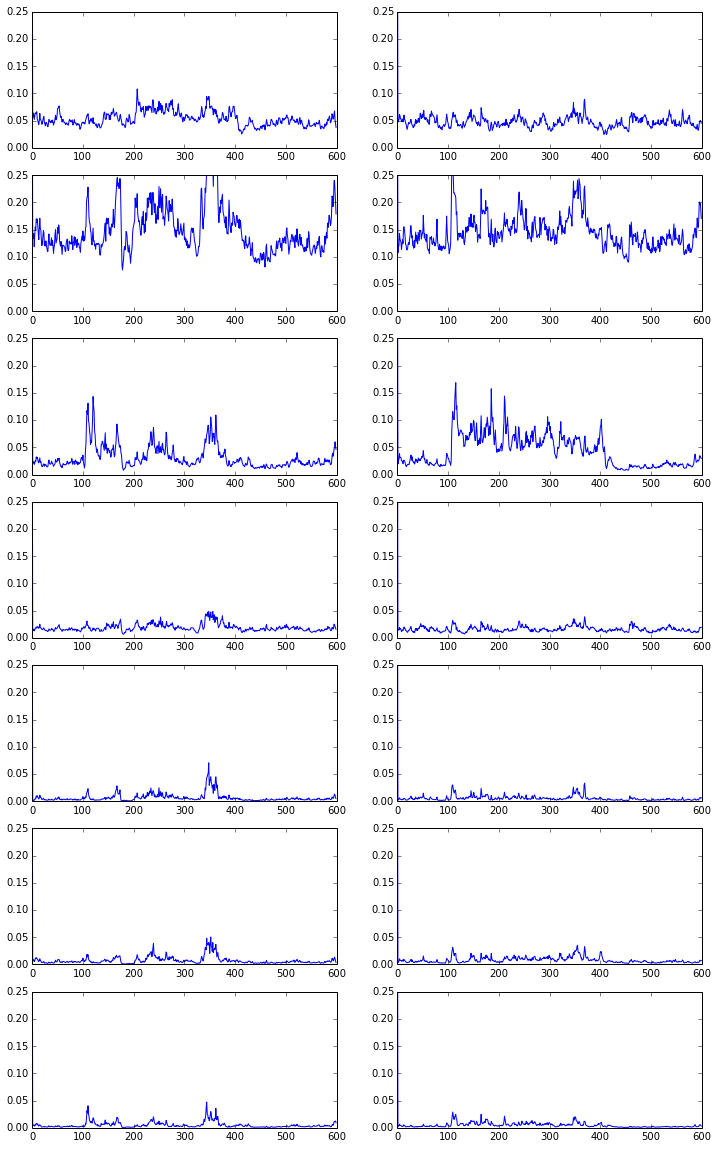

In [81]:
figure(figsize=(12,20))
for cell in range(cells):
    for condition in range(2):
        subplot(7,2,1+ condition + 2*cell)
        plot(models[cell][condition].predict(np.hstack([history_dms[condition][0], rate_dms[cell][condition]])))
        ylim([0,0.25])
    

In [96]:
from scipy.stats import binom
def ll(ps,xs,n=1):
    return binom.logpmf(xs, n, ps).sum()

In [97]:
likelihood = np.zeros((N_test, cells, 2))

for trial in range(N_test):
    test_history_dm = calculate_history_dm(cond_X[:,trial,:], num_knots=history_num_knots, history_length=history_length, order=history_spline_order)
    for cell in range(cells):
        spiketrain = cond_X[cell,trial,:]
        for condition in range(2):
            prediction = models[cell][condition].predict(np.hstack([test_history_dm, rate_dms[cell][condition]]))
            likelihood[trial,cell,condition] = ll(prediction, spiketrain,n=merged_bins)

[ True False False  True False  True  True False False  True  True False
  True False  True  True False False  True False False False  True False
  True False False False False  True  True  True False  True  True  True
  True  True  True False False False  True False]
[ True False False  True False  True  True False False  True  True False
  True False  True  True False False  True False False False  True False
  True False False False False  True  True  True False  True  True  True
  True  True  True False False False  True False]


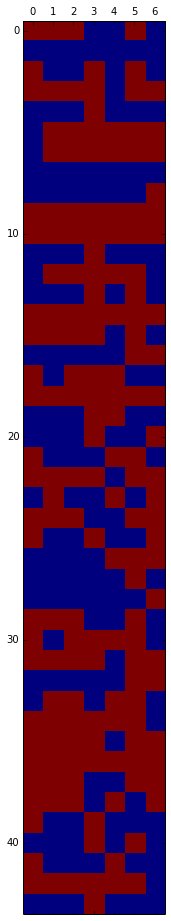

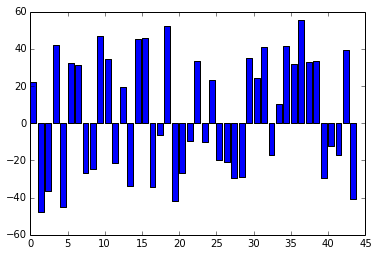

In [108]:
matshow(likelihood[:,:,0] < likelihood[:,:,1])


lld = likelihood[:,:,1].sum(axis=1) - likelihood[:,:,0].sum(axis=1)
figure()
bar(np.arange(N_test),lld )

print lld>0

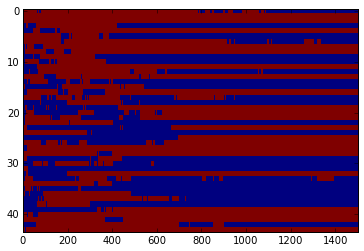

In [58]:
prediction = []
for t in range(data_test.nr_trials):
    dat = data_test.condition(0).trial(t)
    prediction.append((np.array([f.compare(dat)['llf'].cumsum() for f in fitted_models[0]]).sum(0) >
        np.array([f.compare(dat)['llf'].cumsum() for f in fitted_models[1]]).sum(0)))
prediction = 1*np.array(prediction)
imshow(prediction,aspect='auto',interpolation='nearest')

[0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1]

[1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0]

In [68]:
group_name = 'group'

In [70]:
# or use comma separated values

numpy.savetxt(group_name+'_prediction.csv', prediction, fmt='%d', delimiter=',')

That's it for part 5! And the whole course
============================================

(Now you can start on your presentations)